In [250]:
from __future__ import print_function

import pandas as pd 
import numpy as np 
import sklearn

from gensim.models import KeyedVectors
from gensim.models import word2vec
import gensim

# Metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.utils import resample

#Visualization
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

#import custom functions
from src import *

#miscellaneous
import warnings 
warnings.filterwarnings("ignore")
import pickle
from numpy.random import seed
from tensorflow import set_random_seed

In [2]:
import tensorflow as tf
import keras
from keras.preprocessing import text, sequence
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam, rmsprop
from keras import regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import load_model
from keras.callbacks import History 
from keras.callbacks import CSVLogger


Using TensorFlow backend.


In [4]:
with open('data/cleaned-reshuffled.pkl', 'rb') as f:
	df = pickle.load(f)

In [5]:
X = df.tokenized_tweet
y = df.label

In [7]:
X_token_list = list(df.tokenized_tweet)
# X_token_sumlist = sum(X_token_list,[])
# X_unique_tokens = set(X_token_sumlist)

In [8]:
# print('The unique number of words in the dataset is: {}'.format(len(X_unique_tokens)))

In [10]:
max(len(tweet) for tweet in df.no_hash_tweet)

139

In [11]:
max(len(tweet) for tweet in df.tokenized_tweet)

39

In [12]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(list(df.no_hash_tweet))

In [13]:
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 37794 unique tokens


In [14]:
sequences = tokenizer.texts_to_sequences(df['no_hash_tweet'])

In [15]:
sorted(sequences[0])

[1, 1, 2, 9, 67, 102, 122, 189, 311, 1048, 3004, 3813, 5338, 5339]

In [16]:
df.no_hash_tweet[0]

'sad to see the scenes of hooligans pre engrus why spoil the pay euro'

In [17]:
for word, idx in word_index.items():     
    if idx in  sequences[0]:
        print(word, idx)

the 1
to 2
of 9
see 67
why 102
sad 122
pay 189
euro 311
pre 1048
scenes 3004
engrus 3813
hooligans 5338
spoil 5339


In [36]:
# How to get vector representation based on its index. Example:
print(tokenizer.index_word[4])
RNN_w2vmodel300[tokenizer.index_word[4]]

a


array([ 1.21149875e-01,  1.09636448e-01, -2.23487869e-01, -3.66480976e-01,
       -8.60862881e-02,  2.13519230e-01, -1.30308896e-01,  1.99164137e-01,
        3.92002948e-02, -9.75656286e-02,  2.66670078e-01,  4.34957355e-01,
        8.78760666e-02, -4.41437550e-02, -1.64388761e-01, -1.68974400e-01,
        3.10852736e-01,  1.85669556e-01,  1.46013379e-01,  1.92988500e-01,
        1.27472088e-01, -4.80226517e-01,  1.45125404e-01,  1.50890172e-01,
       -8.96715075e-02, -1.20926037e-01, -5.84333204e-02,  9.21065137e-02,
       -1.58688221e-02, -1.67694420e-01, -1.57393828e-01, -2.30456203e-01,
       -2.38595724e-01,  3.55256870e-02,  2.84247279e-01, -2.00440735e-01,
        2.17486277e-01,  3.36508220e-03, -2.95555025e-01,  1.65896937e-01,
        2.08972380e-01, -8.47818106e-02,  8.44274163e-02, -4.75303382e-01,
       -1.72619954e-01,  3.15273255e-01, -9.94405746e-02,  1.35981113e-01,
       -4.22226340e-01,  1.15190424e-01,  2.47159898e-01, -3.08360755e-01,
        3.28465462e-01,  

In [37]:
padded_data = sequence.pad_sequences(sequences, maxlen=39, padding='post')

In [38]:
padded_data

array([[  122,     2,    67, ...,     0,     0,     0],
       [ 9779, 14883,   443, ...,     0,     0,     0],
       [  858,  1400,    13, ...,     0,     0,     0],
       ...,
       [  360,  1069,    47, ...,     0,     0,     0],
       [  720,   113,    47, ...,     0,     0,     0],
       [    1,  2559,  3760, ...,     0,     0,     0]], dtype=int32)

In [39]:
padded_data[1]

array([ 9779, 14883,   443,    27,     2,    18,  2614,     9,     1,
        2053,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0], dtype=int32)

In [40]:
print('Shape of data tensor:', padded_data.shape)

Shape of data tensor: (31962, 39)


In [41]:
embedding_matrix300.shape

(37795, 300)

In [42]:
num_words = len(tokenizer.word_index) + 1
num_words

37795

## Train/Test Split - Full Dataset 

In [43]:
#splitting into train and test 
X_model, X_test, y_model, y_test = train_test_split(padded_data, df.label.values, 
                                                    stratify = df.label.values, test_size=.20, random_state = 123)

In [44]:
#splitting "model" into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, 
                                                    stratify = y_model, test_size = .20, random_state = 123)

### RNN - Model 0

In [601]:
seed(10)
set_random_seed(10)

In [602]:
# init_g = tf.global_variables_initializer()
# init_l = tf.local_variables_initializer()
# with tf.Session() as sess:
#     sess.run(init_g)
#     sess.run(init_l)

In [46]:
model0 = Sequential()

csv_logger = CSVLogger('results/RNN/history_log/model0.training.log')
# filepath = 'results/RNN/models/model1.h5'

callbacks = [EarlyStopping(monitor='val_loss', patience = 5), 
             ReduceLROnPlateau(monitor='val_loss', patience = 5),
             csv_logger]
#              ModelCheckpoint(filepath, save_best_only = True, save_weights_only = True)]

model0.add(Embedding(num_words, 300, weights=[embedding_matrix300], input_length= 39, trainable=False))

model0.add(LSTM(128, return_sequences=True))
model0.add(BatchNormalization())

model0.add(LSTM(64))
model0.add(BatchNormalization())

model0.add(Dense(1, activation='sigmoid'))

model0.compile(loss='binary_crossentropy', optimizer = rmsprop(lr=.00001), metrics=['accuracy'])

print(model0.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 39, 300)           11338500  
_________________________________________________________________
lstm_3 (LSTM)                (None, 39, 128)           219648    
_________________________________________________________________
batch_normalization_2 (Batch (None, 39, 128)           512       
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                49408     
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 11,608,389
Trainable params: 269,505
Non-trainable params: 11,338,884
__________________________________________________________

In [47]:
history = model0.fit(X_train, 
                    y_train,
                    epochs=200,
                    batch_size=50,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val))

Instructions for updating:
Use tf.cast instead.
Train on 20455 samples, validate on 5114 samples
Epoch 1/200
20455/20455 [==============================] - 165s 8ms/step - loss: 0.6844 - acc: 0.6113 - val_loss: 0.6627 - val_acc: 0.6907
Epoch 2/200
20455/20455 [==============================] - 156s 8ms/step - loss: 0.6478 - acc: 0.6844 - val_loss: 0.5808 - val_acc: 0.8066
Epoch 3/200
20455/20455 [==============================] - 155s 8ms/step - loss: 0.6181 - acc: 0.7575 - val_loss: 0.6046 - val_acc: 0.8092
Epoch 4/200
20455/20455 [==============================] - 155s 8ms/step - loss: 0.5929 - acc: 0.8165 - val_loss: 0.6113 - val_acc: 0.8156
Epoch 5/200
20455/20455 [==============================] - 164s 8ms/step - loss: 0.5688 - acc: 0.8495 - val_loss: 0.6576 - val_acc: 0.7595
Epoch 6/200
20455/20455 [==============================] - 166s 8ms/step - loss: 0.5468 - acc: 0.8699 - val_loss: 0.5266 - val_acc: 0.8919
Epoch 7/200
20455/20455 [==============================] - 165s 8ms/s

In [54]:
model0.save_weights('results/RNN/models/model0.weights.h5', overwrite = True)
model0.save('results/RNN/models/model0.h5', overwrite = True)

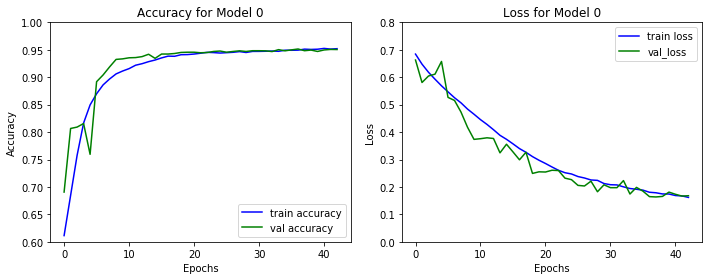

In [48]:
plot_accuracy_loss('Model 0', model0, (.6,1), (0,.8))

In [51]:
y_train_pred0 = model0.predict_classes(X_train, batch_size = 20455)
y_val_pred0 = model0.predict_classes(X_val, batch_size = 5114)
y_train_prob0 = model0.predict_proba(X_train, batch_size = 20455)
y_val_prob0 = model0.predict_proba(X_val, batch_size = 5114)

In [53]:
compare_classification_metrics(y_train, y_train_pred0, y_val, y_val_pred0)

{'Train Accuracy': 0.95,
 'Train Precision': 0.83,
 'Train Recall': 0.45,
 'Train F1': 0.58,
 'Validation Accuracy': 0.95,
 'Validation Precision': 0.76,
 'Validation Recall': 0.43,
 'Validation F1': 0.55}

Adjusted Accuracy: 0.9477903793508017
Adjusted Precision: 0.6619718309859155
Adjusted Recall: 0.5236768802228412
Adjusted F1 Score: 0.5847589424572317




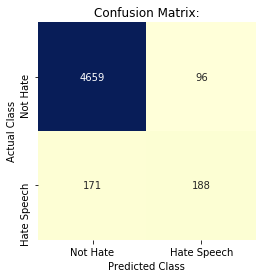

In [61]:
adj_y_val0, cm0 = adjust_threshold_and_score(y_val, y_val_prob0, .4, RNN = True)

## Model 0a: 

In [68]:
model0a = Sequential()

csv_logger = CSVLogger('results/RNN/history_log/model0a.training.log')
# filepath = 'results/RNN/models/model1.h5'

callbacks = [EarlyStopping(monitor='val_loss', patience = 10), 
             ReduceLROnPlateau(monitor='val_loss', patience = 10),
             csv_logger]
#              ModelCheckpoint(filepath, save_best_only = True, save_weights_only = True)]

model0a.add(Embedding(num_words, 300, weights=[embedding_matrix300], input_length= 39, trainable=False))

model0a.add(LSTM(128, return_sequences=True))
model0a.add(BatchNormalization())

model0a.add(LSTM(128))
model0a.add(BatchNormalization())

model0a.add(Dense(1, activation='sigmoid'))

model0a.compile(loss='binary_crossentropy', optimizer = rmsprop(lr=.00001), metrics=['accuracy'])

print(model0a.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 39, 300)           11338500  
_________________________________________________________________
lstm_7 (LSTM)                (None, 39, 128)           219648    
_________________________________________________________________
batch_normalization_6 (Batch (None, 39, 128)           512       
_________________________________________________________________
lstm_8 (LSTM)                (None, 128)               131584    
_________________________________________________________________
batch_normalization_7 (Batch (None, 128)               512       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 11,690,885
Trainable params: 351,873
Non-trainable params: 11,339,012
__________________________________________________________

In [69]:
history = model0a.fit(X_train, 
                    y_train,
                    epochs=200,
                    batch_size=50,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val))

Train on 20455 samples, validate on 5114 samples
Epoch 1/200
20455/20455 [==============================] - 227s 11ms/step - loss: 0.6734 - acc: 0.6240 - val_loss: 0.5212 - val_acc: 0.8844
Epoch 2/200
20455/20455 [==============================] - 204s 10ms/step - loss: 0.6255 - acc: 0.7671 - val_loss: 0.5296 - val_acc: 0.8838
Epoch 3/200
20455/20455 [==============================] - 193s 9ms/step - loss: 0.5884 - acc: 0.8432 - val_loss: 0.4681 - val_acc: 0.9218
Epoch 4/200
20455/20455 [==============================] - 214s 10ms/step - loss: 0.5582 - acc: 0.8739 - val_loss: 0.5732 - val_acc: 0.8672
Epoch 5/200
20455/20455 [==============================] - 193s 9ms/step - loss: 0.5267 - acc: 0.8875 - val_loss: 0.4276 - val_acc: 0.9331
Epoch 6/200
20455/20455 [==============================] - 192s 9ms/step - loss: 0.4989 - acc: 0.9001 - val_loss: 0.3998 - val_acc: 0.9343
Epoch 7/200
20455/20455 [==============================] - 195s 10ms/step - loss: 0.4704 - acc: 0.9120 - val_loss:

In [70]:
model0a.save_weights('results/RNN/models/model0a.weights.h5', overwrite = True)
model0a.save('results/RNN/models/model0a.h5', overwrite = True)

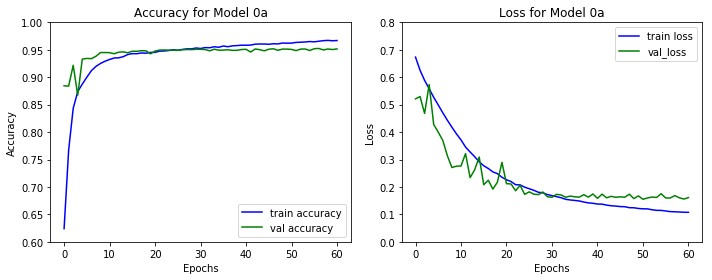

In [96]:
plot_accuracy_loss('Model 0a', model0a, (.6,1), (0,.8))

In [72]:
y_train_pred0a = model0a.predict_classes(X_train, batch_size = 20455)
y_val_pred0a = model0a.predict_classes(X_val, batch_size = 5114)
y_train_prob0a = model0a.predict_proba(X_train, batch_size = 20455)
y_val_prob0a = model0a.predict_proba(X_val, batch_size = 5114)

In [73]:
compare_classification_metrics(y_train, y_train_pred0a, y_val, y_val_pred0a)

{'Train Accuracy': 0.97,
 'Train Precision': 0.96,
 'Train Recall': 0.6,
 'Train F1': 0.74,
 'Validation Accuracy': 0.95,
 'Validation Precision': 0.76,
 'Validation Recall': 0.45,
 'Validation F1': 0.57}

Adjusted Accuracy: 0.9507235041063746
Adjusted Precision: 0.7183673469387755
Adjusted Recall: 0.49025069637883006
Adjusted F1 Score: 0.5827814569536424




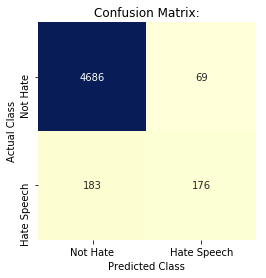

In [74]:
adj_y_val0a, cm0a = adjust_threshold_and_score(y_val, y_val_prob0a, .4, RNN = True)

### RNN 1 - no class weight adjustments

In [591]:
# init = tf.global_variables_initializer()
# with tf.Session() as sess:
#     sess.run(init)

In [75]:
seed(10)
set_random_seed(10)

In [76]:
model1 = Sequential()

csv_logger = CSVLogger('results/RNN/history_log/model1.training.log')
# filepath = 'results/RNN/models/model1.h5'

callbacks = [EarlyStopping(monitor='val_loss', patience = 10), 
             ReduceLROnPlateau(monitor='val_loss', patience = 10),
             csv_logger]
#              ModelCheckpoint(filepath, save_best_only = True, save_weights_only = True)]

model1.add(Embedding(num_words, 300, weights=[embedding_matrix300], input_length= 39, trainable=False))

model1.add(LSTM(64, activation='relu', return_sequences=True))
model1.add(BatchNormalization())

model1.add(LSTM(64, activation='relu'))
model1.add(BatchNormalization())

model1.add(Dense(1, activation='sigmoid'))

model1.compile(loss='binary_crossentropy', optimizer = rmsprop(lr=.00001), metrics=['accuracy'])

print(model1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 39, 300)           11338500  
_________________________________________________________________
lstm_9 (LSTM)                (None, 39, 64)            93440     
_________________________________________________________________
batch_normalization_8 (Batch (None, 39, 64)            256       
_________________________________________________________________
lstm_10 (LSTM)               (None, 32)                12416     
_________________________________________________________________
batch_normalization_9 (Batch (None, 32)                128       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 11,444,773
Trainable params: 106,081
Non-trainable params: 11,338,692
__________________________________________________________

In [77]:
history = model1.fit(X_train, 
                    y_train,
                    epochs=200,
                    batch_size=50,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val))

Train on 20455 samples, validate on 5114 samples
Epoch 1/200
20455/20455 [==============================] - 118s 6ms/step - loss: 0.7455 - acc: 0.4676 - val_loss: 0.7682 - val_acc: 0.7933
Epoch 2/200
20455/20455 [==============================] - 117s 6ms/step - loss: 0.7140 - acc: 0.6415 - val_loss: 0.7581 - val_acc: 0.7489
Epoch 3/200
20455/20455 [==============================] - 109s 5ms/step - loss: 0.6839 - acc: 0.7631 - val_loss: 0.7577 - val_acc: 0.8328
Epoch 4/200
20455/20455 [==============================] - 110s 5ms/step - loss: 0.6539 - acc: 0.8247 - val_loss: 0.6758 - val_acc: 0.8702
Epoch 5/200
20455/20455 [==============================] - 110s 5ms/step - loss: 0.6290 - acc: 0.8601 - val_loss: 0.6612 - val_acc: 0.8999
Epoch 6/200
20455/20455 [==============================] - 110s 5ms/step - loss: 0.6112 - acc: 0.8767 - val_loss: 0.5848 - val_acc: 0.9183
Epoch 7/200
20455/20455 [==============================] - 110s 5ms/step - loss: 0.5947 - acc: 0.8832 - val_loss: 0.5

In [78]:
model1.save_weights('results/RNN/models/model1.weights.h5', overwrite = True)
model1.save('results/RNN/models/model1.h5', overwrite = True)

In [134]:
model1 = load_model('results/RNN/models/model1.h5')

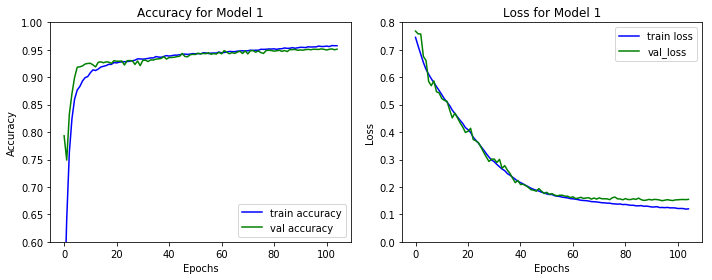

In [79]:
plot_accuracy_loss('Model 1', model1,(.6,1), (0,.8))

In [83]:
y_train_pred1 = model1.predict_classes(X_train, batch_size = 20455)
y_val_pred1 = model1.predict_classes(X_val, batch_size = 5114)
y_train_prob1 = model1.predict_proba(X_train, batch_size = 20455)
y_val_prob1 = model1.predict_proba(X_val, batch_size = 5114)

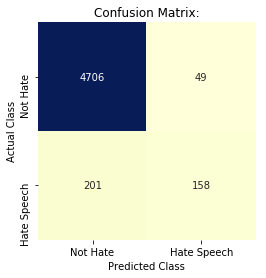

In [87]:
seaborn_confusion_matrix(y_val, y_val_pred1)

In [89]:
compare_classification_metrics(y_train, y_train_pred1, y_val, y_val_pred1)

{'Train Accuracy': 0.96,
 'Train Precision': 0.88,
 'Train Recall': 0.47,
 'Train F1': 0.61,
 'Validation Accuracy': 0.95,
 'Validation Precision': 0.76,
 'Validation Recall': 0.44,
 'Validation F1': 0.56}

In [90]:
pd.DataFrame(y_val_prob1).describe()

,0
count,5114.000000
mean,0.065470
std,0.163814
min,0.000000
25%,0.006414
50%,0.011144
75%,0.035260
max,1.000000


Adjusted Accuracy: 0.9403597966366836
Adjusted Precision: 0.5692307692307692
Adjusted Recall: 0.6183844011142061
Adjusted F1 Score: 0.5927903871829105




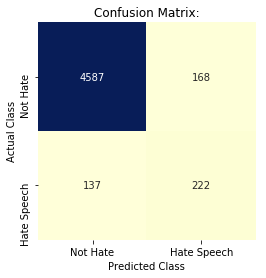

In [105]:
adj_y_val1, cm1 = adjust_threshold_and_score(y_val, y_val_prob1, .2, RNN = True)

### RNN 2 - class weights 

In [106]:
model2 = Sequential()

# filepath = 'results/RNN/weights_model2.best.hdf5'

callbacks = [EarlyStopping(monitor='val_loss', patience = 10), 
             ReduceLROnPlateau(monitor='val_loss', patience = 10)]
#              ModelCheckpoint(filepath, save_best_only = True, save_weights_only = True)]

model2.add(Embedding(num_words, 300, weights=[embedding_matrix300], input_length= 39, trainable=False))

model2.add(LSTM(64, activation='relu', return_sequences=True))
model2.add(BatchNormalization())

model2.add(LSTM(64, activation='relu'))
model2.add(BatchNormalization())

model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy', optimizer = rmsprop(lr=.00001), metrics=['accuracy']) #optimizer=Adam

print(model2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 39, 300)           11338500  
_________________________________________________________________
lstm_13 (LSTM)               (None, 39, 64)            93440     
_________________________________________________________________
batch_normalization_12 (Batc (None, 39, 64)            256       
_________________________________________________________________
lstm_14 (LSTM)               (None, 64)                33024     
_________________________________________________________________
batch_normalization_13 (Batc (None, 64)                256       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 11,465,541
Trainable params: 126,785
Non-trainable params: 11,338,756
__________________________________________________________

In [107]:
history = model2.fit(X_train, 
                    y_train,
                    epochs=200,
                    batch_size=50,
                    callbacks=callbacks,
                    class_weight=[{0:1,1:10}],
                    validation_data=(X_val, y_val))

Train on 20455 samples, validate on 5114 samples
Epoch 1/200
20455/20455 [==============================] - 146s 7ms/step - loss: 1.1246 - acc: 0.3884 - val_loss: 0.6577 - val_acc: 0.7898
Epoch 2/200
20455/20455 [==============================] - 130s 6ms/step - loss: 1.0781 - acc: 0.4903 - val_loss: 0.6467 - val_acc: 0.8095
Epoch 3/200
20455/20455 [==============================] - 124s 6ms/step - loss: 1.0229 - acc: 0.5384 - val_loss: 0.6843 - val_acc: 0.4896
Epoch 4/200
20455/20455 [==============================] - 129s 6ms/step - loss: 0.9493 - acc: 0.5814 - val_loss: 0.6549 - val_acc: 0.6758
Epoch 5/200
20455/20455 [==============================] - 139s 7ms/step - loss: 0.8808 - acc: 0.6352 - val_loss: 0.6137 - val_acc: 0.7268
Epoch 6/200
20455/20455 [==============================] - 141s 7ms/step - loss: 0.8404 - acc: 0.6704 - val_loss: 0.5520 - val_acc: 0.7669
Epoch 7/200
20455/20455 [==============================] - 128s 6ms/step - loss: 0.8093 - acc: 0.7132 - val_loss: 0.5

In [138]:
model2.save('results/RNN/models/model2.h5', overwrite = True)
model2.save_weights('results/RNN//models/model2.weights.h5', overwrite = True)
# model2 = load_model('results/RNN/model2.h5')

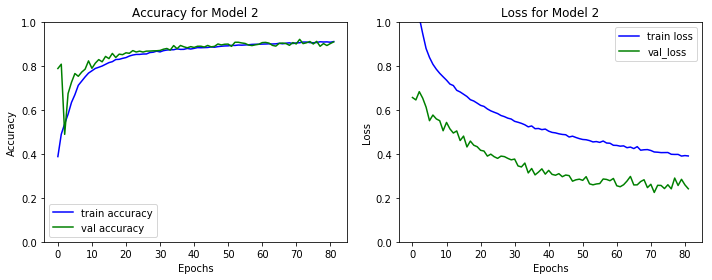

In [109]:
plot_accuracy_loss('Model 2', model2, (0, 1), (0,1))

In [110]:
y_train_pred2 = model2.predict_classes(X_train, batch_size = 20455)
y_val_pred2 = model2.predict_classes(X_val, batch_size= 5114)
y_train_prob2 = model2.predict_proba(X_train, batch_size= 20455)
y_val_prob2 = model2.predict_proba(X_val, batch_size = 5114)

In [112]:
compare_classification_metrics(y_train, y_train_pred2, y_val, y_val_pred2)

{'Train Accuracy': 0.94,
 'Train Precision': 0.53,
 'Train Recall': 0.87,
 'Train F1': 0.65,
 'Validation Accuracy': 0.91,
 'Validation Precision': 0.42,
 'Validation Recall': 0.7,
 'Validation F1': 0.53}

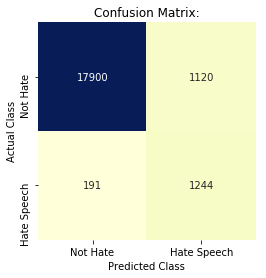

In [114]:
seaborn_confusion_matrix(y_train, y_train_pred2)

In [115]:
pd.DataFrame(y_train_prob2).describe()

,0
count,20455.000000
mean,0.169647
std,0.245092
min,0.000000
25%,0.039388
50%,0.057638
75%,0.145868
max,1.000000


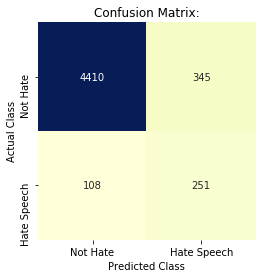

In [116]:
seaborn_confusion_matrix(y_val, y_val_pred2)

Adjusted Accuracy: 0.943097379741885
Adjusted Precision: 0.6036585365853658
Adjusted Recall: 0.5515320334261838
Adjusted F1 Score: 0.5764192139737991




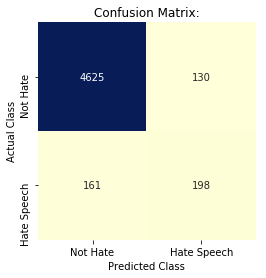

In [117]:
adj_y_val2, cm2 = adjust_threshold_and_score(y_val, y_val_prob2, .8, RNN = True)

## RNN 2b - class weights with larger batch size (100)

In [120]:
model2b = Sequential()

# filepath = 'results/RNN/weights_model2b.best.hdf5'

callbacks = [EarlyStopping(monitor='val_loss', patience = 15), 
             ReduceLROnPlateau(monitor='val_loss', patience = 15)]
#              ModelCheckpoint(filepath, save_best_only = True, save_weights_only = True)]

model2b.add(Embedding(num_words, 300, weights=[embedding_matrix300], input_length= 39, trainable=False))

model2b.add(LSTM(64, activation='relu', return_sequences=True))
model2b.add(BatchNormalization())

model2b.add(LSTM(64, activation='relu'))
model2b.add(BatchNormalization())

model2b.add(Dense(1, activation='sigmoid'))

model2b.compile(loss='binary_crossentropy', optimizer = rmsprop(lr=.000001), metrics=['accuracy']) #optimizer=Adam

print(model2b.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 39, 300)           11338500  
_________________________________________________________________
lstm_15 (LSTM)               (None, 39, 64)            93440     
_________________________________________________________________
batch_normalization_14 (Batc (None, 39, 64)            256       
_________________________________________________________________
lstm_16 (LSTM)               (None, 64)                33024     
_________________________________________________________________
batch_normalization_15 (Batc (None, 64)                256       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 11,465,541
Trainable params: 126,785
Non-trainable params: 11,338,756
__________________________________________________________

In [121]:
history = model2b.fit(X_train, 
                    y_train,
                    epochs=200,
                    batch_size=100,
                    callbacks=callbacks,
                    class_weight=[{0:1,1:10}],
                    validation_data=(X_val, y_val))

Train on 20455 samples, validate on 5114 samples
Epoch 1/200
20455/20455 [==============================] - 112s 5ms/step - loss: 1.3424 - acc: 0.4873 - val_loss: 0.7417 - val_acc: 0.1406
Epoch 2/200
20455/20455 [==============================] - 93s 5ms/step - loss: 1.2722 - acc: 0.5322 - val_loss: 0.7426 - val_acc: 0.1343
Epoch 3/200
20455/20455 [==============================] - 86s 4ms/step - loss: 1.2321 - acc: 0.5446 - val_loss: 0.7261 - val_acc: 0.1592
Epoch 4/200
20455/20455 [==============================] - 89s 4ms/step - loss: 1.1872 - acc: 0.5550 - val_loss: 0.7281 - val_acc: 0.1570
Epoch 5/200
20455/20455 [==============================] - 98s 5ms/step - loss: 1.1565 - acc: 0.5589 - val_loss: 0.7324 - val_acc: 0.1641
Epoch 6/200
20455/20455 [==============================] - 81s 4ms/step - loss: 1.1443 - acc: 0.5552 - val_loss: 0.7426 - val_acc: 0.1662
Epoch 7/200
20455/20455 [==============================] - 86s 4ms/step - loss: 1.1286 - acc: 0.5389 - val_loss: 0.7411 - 

Epoch 118/200
20455/20455 [==============================] - 88s 4ms/step - loss: 0.7832 - acc: 0.7518 - val_loss: 0.5766 - val_acc: 0.7587
Epoch 119/200
20455/20455 [==============================] - 87s 4ms/step - loss: 0.7785 - acc: 0.7524 - val_loss: 0.5684 - val_acc: 0.7695
Epoch 120/200
20455/20455 [==============================] - 79s 4ms/step - loss: 0.7783 - acc: 0.7522 - val_loss: 0.5692 - val_acc: 0.7710
Epoch 121/200
20455/20455 [==============================] - 85s 4ms/step - loss: 0.7742 - acc: 0.7581 - val_loss: 0.5659 - val_acc: 0.7763
Epoch 122/200
20455/20455 [==============================] - 86s 4ms/step - loss: 0.7716 - acc: 0.7549 - val_loss: 0.5537 - val_acc: 0.7867
Epoch 123/200
20455/20455 [==============================] - 80s 4ms/step - loss: 0.7736 - acc: 0.7597 - val_loss: 0.5647 - val_acc: 0.7761
Epoch 124/200
20455/20455 [==============================] - 84s 4ms/step - loss: 0.7717 - acc: 0.7555 - val_loss: 0.5636 - val_acc: 0.7734
Epoch 125/200
20455/

In [140]:
model2b.save ('results/RNN/models/model2b.h5', overwrite = True)
model2b.save_weights ('results/RNN/models/model2b.weights.h5', overwrite = True)
# model2b = load_model('results/RNN/models/model2b.h5')

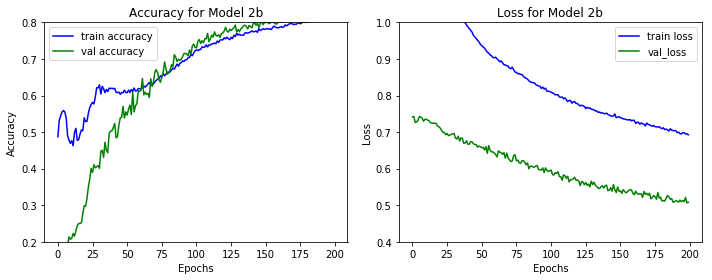

In [124]:
plot_accuracy_loss('Model 2b', model2b, (.2, .8), (.4, 1))

In [126]:
y_train_pred2b = model2b.predict_classes(X_train, batch_size = 20455)
y_val_pred2b = model2b.predict_classes(X_val, batch_size = 5144)
y_train_prob2b = model2b.predict_proba(X_train, batch_size = 20455)
y_val_prob2b = model2b.predict_proba(X_val, batch_size = 5114)

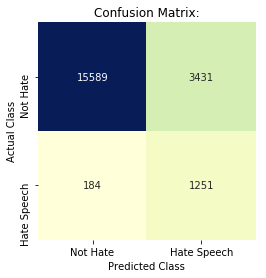

In [127]:
seaborn_confusion_matrix(y_train, y_train_pred2b)

In [128]:
pd.DataFrame(y_train_prob2b).describe()

,0
count,20455.000000
mean,0.389875
std,0.207147
min,0.000000
25%,0.243242
50%,0.324086
75%,0.478435
max,1.000000


In [130]:
compare_classification_metrics(y_train, y_train_pred2b, y_val, y_val_pred2b)

{'Train Accuracy': 0.82,
 'Train Precision': 0.27,
 'Train Recall': 0.87,
 'Train F1': 0.41,
 'Validation Accuracy': 0.82,
 'Validation Precision': 0.26,
 'Validation Recall': 0.87,
 'Validation F1': 0.4}

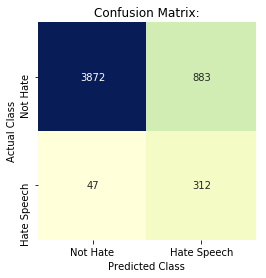

In [131]:
seaborn_confusion_matrix(y_val, y_val_pred2b)

Adjusted Accuracy: 0.932733672272194
Adjusted Precision: 0.5203252032520326
Adjusted Recall: 0.5348189415041783
Adjusted F1 Score: 0.5274725274725275




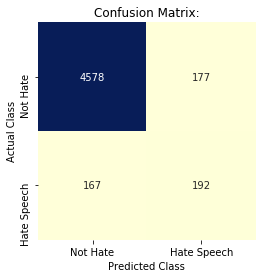

In [132]:
adj_y_val2b, cm2b = adjust_threshold_and_score(y_val, y_val_prob2b, .8, RNN = True)

# RNN 3 - upsampling # 1 - lr .000001, patience 10

In [144]:
X_train_up, y_train_up = upsample_training_data(X_train, y_train)

In [145]:
model3 = Sequential()

# filepath = 'results/RNN/models/model3_weights.best.hdf5'

callbacks = [EarlyStopping(monitor='val_loss', patience = 10), 
             ReduceLROnPlateau(monitor='val_loss', patience = 10)]
#              ModelCheckpoint(filepath, save_best_only = True, save_weights_only = True)]

model3.add(Embedding(num_words, 300, weights=[embedding_matrix300], input_length= 39, trainable=False))

model3.add(LSTM(64, activation='relu', return_sequences=True))
model3.add(BatchNormalization())

model3.add(LSTM(64, activation='relu'))
model3.add(BatchNormalization())

model3.add(Dense(1, activation='sigmoid'))

model3.compile(loss='binary_crossentropy', optimizer = rmsprop(lr=.000001), metrics=['accuracy']) #optimizer=Adam

print(model3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 39, 300)           11338500  
_________________________________________________________________
lstm_19 (LSTM)               (None, 39, 64)            93440     
_________________________________________________________________
batch_normalization_18 (Batc (None, 39, 64)            256       
_________________________________________________________________
lstm_20 (LSTM)               (None, 64)                33024     
_________________________________________________________________
batch_normalization_19 (Batc (None, 64)                256       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 11,465,541
Trainable params: 126,785
Non-trainable params: 11,338,756
__________________________________________________________

In [146]:
history = model3.fit(X_train_up, 
                    y_train_up,
                    epochs=200,
                    batch_size=50,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val))

Train on 38040 samples, validate on 5114 samples
Epoch 1/200
38040/38040 [==============================] - 299s 8ms/step - loss: 0.6594 - acc: 0.6314 - val_loss: 0.6993 - val_acc: 0.5645
Epoch 2/200
38040/38040 [==============================] - 252s 7ms/step - loss: 0.6398 - acc: 0.6571 - val_loss: 0.6778 - val_acc: 0.7104
Epoch 3/200
38040/38040 [==============================] - 262s 7ms/step - loss: 0.6220 - acc: 0.6872 - val_loss: 0.6586 - val_acc: 0.7894
Epoch 4/200
38040/38040 [==============================] - 284s 7ms/step - loss: 0.6039 - acc: 0.7146 - val_loss: 0.6538 - val_acc: 0.7765
Epoch 5/200
38040/38040 [==============================] - 271s 7ms/step - loss: 0.5828 - acc: 0.7392 - val_loss: 0.6336 - val_acc: 0.7814
Epoch 6/200
38040/38040 [==============================] - 255s 7ms/step - loss: 0.5597 - acc: 0.7571 - val_loss: 0.5990 - val_acc: 0.8088
Epoch 7/200
38040/38040 [==============================] - 251s 7ms/step - loss: 0.5350 - acc: 0.7703 - val_loss: 0.5

In [147]:
model3.save('results/RNN/models/model3.h5', overwrite = True)
model3.save_weights('results/RNN/models/model3.weights.h5', overwrite = True)
# model3 = load_model('results/RNN/models/model3_300.h5')

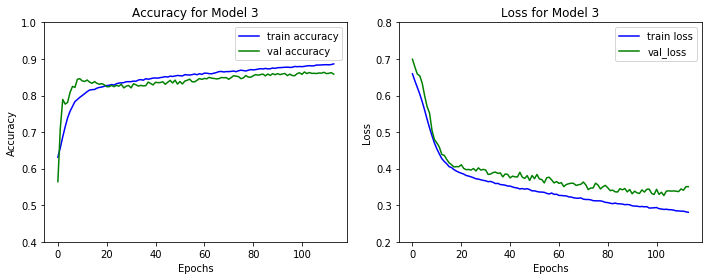

In [249]:
plot_accuracy_loss('Model 3', model3, (.4, 1), (.2, .8))

In [149]:
y_train_pred3 = model3.predict_classes(X_train_up, batch_size = 38040)
y_val_pred3 = model3.predict_classes(X_val, batch_size = 5114)
y_train_prob3 = model3.predict_proba(X_train_up, batch_size = 38040)
y_val_prob3 = model3.predict_proba(X_val, batch_size = 5114)

In [150]:
pd.DataFrame(y_train_prob3).describe()

,0
count,38040.000000
mean,0.504782
std,0.389341
min,0.000000
25%,0.067581
50%,0.551679
75%,0.908788
max,1.000000


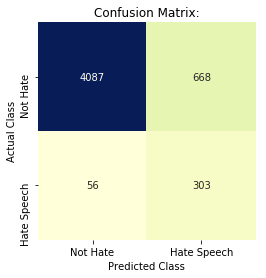

In [152]:
seaborn_confusion_matrix(y_val, y_val_pred3)

In [153]:
compare_classification_metrics(y_train_up, y_train_pred3, y_val, y_val_pred3)

{'Train Accuracy': 0.89,
 'Train Precision': 0.88,
 'Train Recall': 0.91,
 'Train F1': 0.89,
 'Validation Accuracy': 0.86,
 'Validation Precision': 0.31,
 'Validation Recall': 0.84,
 'Validation F1': 0.46}

Adjusted Accuracy: 0.9278451310129058
Adjusted Precision: 0.4894957983193277
Adjusted Recall: 0.649025069637883
Adjusted F1 Score: 0.5580838323353292




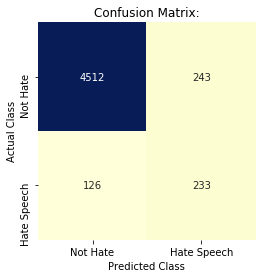

In [154]:
y_adj_val3, cm3 = adjust_threshold_and_score (y_val, y_val_prob3, .8, RNN = True)

## RNN 3b - Upsampling   
increased learning rate to .0001 before, which increased adj F1 to .58... now decreasing again.

Decreased learning rate to .00001-->  decreased adjusted F1 to .51

Now increasing learning rate to .001  --> reduced F1 to .42 

(lr=.0001) and batch size 100 -->. adj F1 is .57 -- maybe reduce batch size again?  

 ---> reduced batch size to 50 and got F1 of .58, but graph is all straight lines.... try reducing learning rate again to .00001?  --> curved lines, but reduced F1 to .47 by doing this
 
 now trying to add dropout - add two dropout layers of .01, and got adjusted F1 to .55
 
 now trying to increase dropout to .2

In [155]:
model3b = Sequential()

# filepath = 'results/RNN/weights.best.hdf5'

callbacks = [EarlyStopping(monitor='val_loss', patience = 10), 
             ReduceLROnPlateau(monitor='val_loss', patience = 10)]
#              ModelCheckpoint(filepath, save_best_only = True, save_weights_only = True)]

model3b.add(Embedding(num_words, 300, weights=[embedding_matrix300], input_length= 39, trainable=False))

model3b.add(LSTM(64, activation='relu', return_sequences=True))
model3b.add(BatchNormalization())
model3b.add(Dropout(.2))

model3b.add(LSTM(64, activation='relu'))
model3b.add(BatchNormalization())
model3b.add(Dropout(.2))

model3b.add(Dense(1, activation='sigmoid'))

model3b.compile(loss='binary_crossentropy', optimizer = rmsprop(lr=.0001), metrics=['accuracy']) 

print(model3b.summary())

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 39, 300)           11338500  
_________________________________________________________________
lstm_21 (LSTM)               (None, 39, 64)            93440     
_________________________________________________________________
batch_normalization_20 (Batc (None, 39, 64)            256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 39, 64)            0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 64)                33024     
_________________________________________________________________
batch_normalization_21 (Batc (None, 64)                256       
___________________________

In [156]:
history = model3b.fit(X_train_up, 
                    y_train_up,
                    epochs=200,
                    batch_size=50,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val))

Train on 38040 samples, validate on 5114 samples
Epoch 1/200
38040/38040 [==============================] - 341s 9ms/step - loss: 0.4468 - acc: 0.7858 - val_loss: 0.3630 - val_acc: 0.8479
Epoch 2/200
38040/38040 [==============================] - 257s 7ms/step - loss: 0.3503 - acc: 0.8524 - val_loss: 0.3595 - val_acc: 0.8352
Epoch 3/200
38040/38040 [==============================] - 264s 7ms/step - loss: 0.3052 - acc: 0.8739 - val_loss: 0.3112 - val_acc: 0.8784
Epoch 4/200
38040/38040 [==============================] - 256s 7ms/step - loss: 0.2722 - acc: 0.8878 - val_loss: 0.3284 - val_acc: 0.8510
Epoch 5/200
38040/38040 [==============================] - 257s 7ms/step - loss: 0.2509 - acc: 0.9005 - val_loss: 0.2538 - val_acc: 0.8936
Epoch 6/200
38040/38040 [==============================] - 255s 7ms/step - loss: 0.2409 - acc: 0.9064 - val_loss: 0.3507 - val_acc: 0.8442
Epoch 7/200
38040/38040 [==============================] - 253s 7ms/step - loss: 0.2411 - acc: 0.9049 - val_loss: 0.3

In [157]:
model3b.save('results/RNN/models/model3b.h5', overwrite = True)
model3b.save_weights('results/RNN/models/model3b.weights.h5', overwrite = True)
# model3b = load_model('results/RNN/models/model3b.h5')

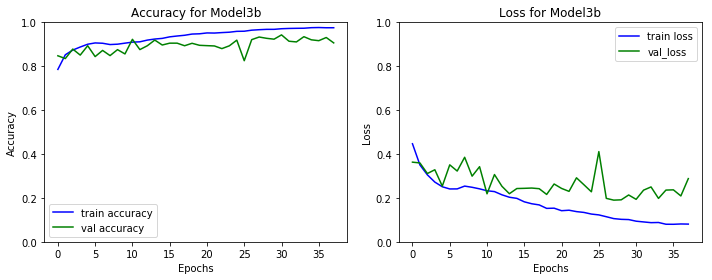

In [158]:
plot_accuracy_loss ('Model3b', model3b, (0,1), (0,1))

In [159]:
y_train_pred3b = model3b.predict_classes(X_train_up, batch_size = 38040)
y_val_pred3b = model3b.predict_classes(X_val, batch_size = 5114)
y_train_prob3b = model3b.predict_proba(X_train_up, batch_size = 5114)
y_val_prob3b = model3b.predict_proba(X_val, batch_size = 38040)

In [160]:
pd.DataFrame(y_train_prob3b).describe()

,0
count,38040.000000
mean,0.514009
std,0.477402
min,0.000000
25%,0.003928
50%,0.901771
75%,0.980069
max,1.000000


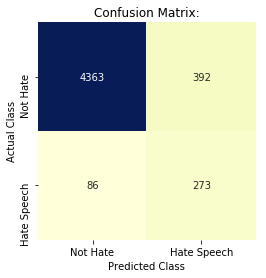

In [162]:
seaborn_confusion_matrix(y_val, y_val_pred3b)

In [163]:
compare_classification_metrics(y_train_up, y_train_pred3b, y_val, y_val_pred3b)

{'Train Accuracy': 0.98,
 'Train Precision': 0.95,
 'Train Recall': 1.0,
 'Train F1': 0.98,
 'Validation Accuracy': 0.91,
 'Validation Precision': 0.41,
 'Validation Recall': 0.76,
 'Validation F1': 0.53}

Adjusted Accuracy: 0.9225655064528745
Adjusted Precision: 0.466786355475763
Adjusted Recall: 0.724233983286908
Adjusted F1 Score: 0.5676855895196506




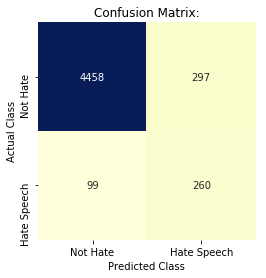

In [164]:
y_adj_val3b, cm3b = adjust_threshold_and_score(y_val, y_val_prob3b, .8, RNN = True)

## RNN 3c - upsampling - removing dropout

In [166]:
model3c = Sequential()

# filepath = 'results/RNN/weights_3c.best.hdf5'

callbacks = [EarlyStopping(monitor='val_loss', patience = 10), 
             ReduceLROnPlateau(monitor='val_loss', patience = 10)]
#              ModelCheckpoint(filepath, save_best_only = True, save_weights_only = True)]

model3c.add(Embedding(num_words, 300, weights=[embedding_matrix300], input_length= 39, trainable=False))

model3c.add(LSTM(64, activation='relu', return_sequences=True))
model3c.add(BatchNormalization())

model3c.add(LSTM(64, activation='relu'))
model3c.add(BatchNormalization())

model3c.add(Dense(1, activation='sigmoid'))

model3c.compile(loss='binary_crossentropy', optimizer = rmsprop(lr=.0001), metrics=['accuracy']) #optimizer=Adam

print(model3c.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 39, 300)           11338500  
_________________________________________________________________
lstm_23 (LSTM)               (None, 39, 64)            93440     
_________________________________________________________________
batch_normalization_22 (Batc (None, 39, 64)            256       
_________________________________________________________________
lstm_24 (LSTM)               (None, 64)                33024     
_________________________________________________________________
batch_normalization_23 (Batc (None, 64)                256       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 11,465,541
Trainable params: 126,785
Non-trainable params: 11,338,756
__________________________________________________________

In [167]:
history = model3c.fit(X_train_up, 
                    y_train_up,
                    epochs=200,
                    batch_size=50,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val))

Train on 38040 samples, validate on 5114 samples
Epoch 1/200
38040/38040 [==============================] - 316s 8ms/step - loss: 0.4111 - acc: 0.8128 - val_loss: 0.3496 - val_acc: 0.8481
Epoch 2/200
38040/38040 [==============================] - 286s 8ms/step - loss: 0.3003 - acc: 0.8754 - val_loss: 0.2994 - val_acc: 0.8887
Epoch 3/200
38040/38040 [==============================] - 279s 7ms/step - loss: 0.2476 - acc: 0.9021 - val_loss: 0.3965 - val_acc: 0.8283
Epoch 4/200
38040/38040 [==============================] - 282s 7ms/step - loss: 0.2000 - acc: 0.9252 - val_loss: 0.1809 - val_acc: 0.9345
Epoch 5/200
38040/38040 [==============================] - 7726s 203ms/step - loss: 0.1670 - acc: 0.9400 - val_loss: 0.3994 - val_acc: 0.8387
Epoch 6/200
38040/38040 [==============================] - 328s 9ms/step - loss: 0.1377 - acc: 0.9537 - val_loss: 0.2566 - val_acc: 0.9126
Epoch 7/200
38040/38040 [==============================] - 300s 8ms/step - loss: 0.1164 - acc: 0.9626 - val_loss: 

In [168]:
model3c.save('results/RNN/models/model3c.h5', overwrite = True)
model3c.save_weights('results/RNN/models/model3c.weights.h5', overwrite = True)
# model3 = load_model('results/RNN/models/model3c.h5')

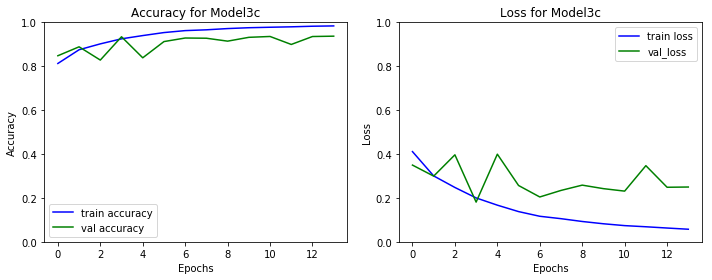

In [188]:
plot_accuracy_loss ('Model3c', model3c, (0,1), (0,1))

In [170]:
y_train_pred3c = model3c.predict_classes(X_train_up, batch_size = 38040)
y_val_pred3c = model3c.predict_classes(X_val, batch_size = 5114)
y_train_prob3c = model3c.predict_proba(X_train_up, batch_size = 38040)
y_val_prob3c = model3c.predict_proba(X_val, batch_size = 5114)

In [171]:
pd.DataFrame(y_train_pred3c).describe()

,0
count,38040.000000
mean,0.501919
std,0.500003
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [174]:
compare_classification_metrics(y_train_up, y_train_pred3c, y_val, y_val_pred3c)

{'Train Accuracy': 0.99,
 'Train Precision': 0.99,
 'Train Recall': 0.99,
 'Train F1': 0.99,
 'Validation Accuracy': 0.94,
 'Validation Precision': 0.55,
 'Validation Recall': 0.62,
 'Validation F1': 0.58}

Adjusted Accuracy: 0.9372311302307391
Adjusted Precision: 0.5467980295566502
Adjusted Recall: 0.6183844011142061
Adjusted F1 Score: 0.580392156862745




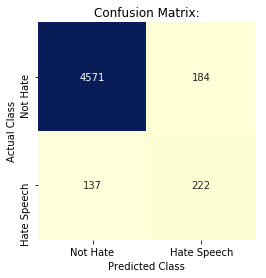

In [185]:
y_adj_val3c, cm3c = adjust_threshold_and_score(y_val, y_val_pred3c, .001, RNN = True)

## RNN 3c2c - upsampling with increased patience, epochs and lower learning rate

In [226]:
model3c2c = Sequential()

# filepath = 'results/RNN/weights_3c2c.best.hdf5'

callbacks = [EarlyStopping(monitor='val_loss', patience = 30), 
             ReduceLROnPlateau(monitor='val_loss', patience = 30)]
#              ModelCheckpoint(filepath, save_best_only = True, save_weights_only = True)]

model3c2c.add(Embedding(num_words, 300, weights=[embedding_matrix300], input_length= 39, trainable=False))

model3c2c.add(LSTM(64, activation='relu', return_sequences=True))
model3c2c.add(BatchNormalization())

model3c2c.add(LSTM(64, activation='relu'))
model3c2c.add(BatchNormalization())

model3c2c.add(Dense(1, activation='sigmoid'))

model3c2c.compile(loss='binary_crossentropy', optimizer = rmsprop(lr=.00001), metrics=['accuracy']) #optimizer=Adam

print(model3c2c.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 39, 300)           11338500  
_________________________________________________________________
lstm_36 (LSTM)               (None, 39, 64)            93440     
_________________________________________________________________
batch_normalization_35 (Batc (None, 39, 64)            256       
_________________________________________________________________
lstm_37 (LSTM)               (None, 64)                33024     
_________________________________________________________________
batch_normalization_36 (Batc (None, 64)                256       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 11,465,541
Trainable params: 126,785
Non-trainable params: 11,338,756
__________________________________________________________

In [227]:
history = model3c2c.fit(X_train_up, 
                    y_train_up,
                    epochs=250,
                    batch_size=50,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val))

Train on 38040 samples, validate on 5114 samples
Epoch 1/250
38040/38040 [==============================] - 259s 7ms/step - loss: 0.6697 - acc: 0.6157 - val_loss: 0.6976 - val_acc: 0.5624
Epoch 2/250
38040/38040 [==============================] - 219s 6ms/step - loss: 0.4842 - acc: 0.7832 - val_loss: 0.4969 - val_acc: 0.7673
Epoch 3/250
38040/38040 [==============================] - 215s 6ms/step - loss: 0.3915 - acc: 0.8254 - val_loss: 0.3985 - val_acc: 0.8224
Epoch 4/250
38040/38040 [==============================] - 215s 6ms/step - loss: 0.3634 - acc: 0.8406 - val_loss: 0.3644 - val_acc: 0.8412
Epoch 5/250
38040/38040 [==============================] - 214s 6ms/step - loss: 0.3479 - acc: 0.8511 - val_loss: 0.3937 - val_acc: 0.8219
Epoch 6/250
38040/38040 [==============================] - 214s 6ms/step - loss: 0.3365 - acc: 0.8560 - val_loss: 0.4000 - val_acc: 0.8156
Epoch 7/250
38040/38040 [==============================] - 214s 6ms/step - loss: 0.3272 - acc: 0.8620 - val_loss: 0.3

38040/38040 [==============================] - 214s 6ms/step - loss: 0.0847 - acc: 0.9755 - val_loss: 0.2416 - val_acc: 0.9265
Epoch 60/250
38040/38040 [==============================] - 213s 6ms/step - loss: 0.0795 - acc: 0.9771 - val_loss: 0.2582 - val_acc: 0.9247
Epoch 61/250
38040/38040 [==============================] - 214s 6ms/step - loss: 0.0789 - acc: 0.9770 - val_loss: 0.2518 - val_acc: 0.9237
Epoch 62/250
38040/38040 [==============================] - 215s 6ms/step - loss: 0.0770 - acc: 0.9781 - val_loss: 0.2460 - val_acc: 0.9284
Epoch 63/250
38040/38040 [==============================] - 214s 6ms/step - loss: 0.0765 - acc: 0.9780 - val_loss: 0.2542 - val_acc: 0.9273
Epoch 64/250
38040/38040 [==============================] - 214s 6ms/step - loss: 0.0742 - acc: 0.9787 - val_loss: 0.2773 - val_acc: 0.9185
Epoch 65/250
38040/38040 [==============================] - 215s 6ms/step - loss: 0.0718 - acc: 0.9797 - val_loss: 0.2676 - val_acc: 0.9183
Epoch 66/250
38040/38040 [=======

In [228]:
model3c2c.save('results/RNN/models/model3c2c.h5', overwrite = True)
model3c2c.save_weights('results/RNN/models/model3c2c.weights.h5', overwrite = True)
# model3c2c = load_model('results/RNN/models/model3c2c.h5')

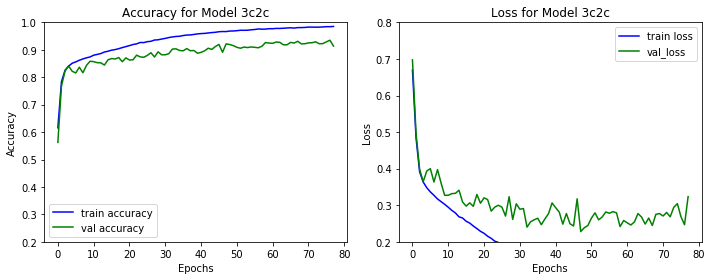

In [229]:
plot_accuracy_loss('Model 3c2c', model3c2c, (.2, 1), ((.2, .8)))

In [230]:
y_train_pred3c2c= model3c2c.predict_classes(X_train_up, batch_size = 38040)
y_val_pred3c2c= model3c2c.predict_classes(X_val, batch_size = 5114)
y_train_prob3c2c = model3c2c.predict_proba(X_train_up, batch_size = 38040)
y_val_prob3c2c = model3c2c.predict_proba(X_val, batch_size = 5114)

In [231]:
compare_classification_metrics(y_train_up, y_train_pred3c2c, y_val, y_val_pred3c2c)

{'Train Accuracy': 0.98,
 'Train Precision': 0.97,
 'Train Recall': 1.0,
 'Train F1': 0.98,
 'Validation Accuracy': 0.91,
 'Validation Precision': 0.43,
 'Validation Recall': 0.7,
 'Validation F1': 0.53}

Adjusted Accuracy: 0.9309737974188502
Adjusted Precision: 0.5065217391304347
Adjusted Recall: 0.649025069637883
Adjusted F1 Score: 0.5689865689865689




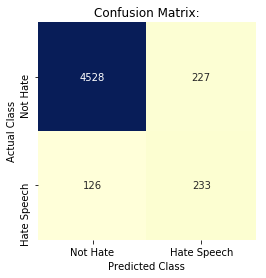

In [232]:
adj3c2c, cm3c2c = adjust_threshold_and_score(y_val, y_val_prob3c2c, .9, RNN = True)

## RNN 3c2b - upsampling with increased patience, dropout .01

In [219]:
model3c2b = Sequential()

# filepath = 'results/RNN/models/weights_3c2b.best.hdf5'

callbacks = [EarlyStopping(monitor='val_loss', patience = 30), 
             ReduceLROnPlateau(monitor='val_loss', patience = 30)]
#              ModelCheckpoint(filepath, save_best_only = True, save_weights_only = True)]

model3c2b.add(Embedding(num_words, 300, weights=[embedding_matrix300], input_length= 39, trainable=False))

model3c2b.add(LSTM(64, activation='relu', return_sequences=True))
model3c2b.add(BatchNormalization())
model3c2b.add(Dropout(.01))

model3c2b.add(LSTM(64, activation='relu'))
model3c2b.add(BatchNormalization())
model3c2b.add(Dropout(.01))

model3c2b.add(Dense(1, activation='sigmoid'))

model3c2b.compile(loss='binary_crossentropy', optimizer = rmsprop(lr=.00001), metrics=['accuracy']) #optimizer=Adam

print(model3c2b.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 39, 300)           11338500  
_________________________________________________________________
lstm_34 (LSTM)               (None, 39, 64)            93440     
_________________________________________________________________
batch_normalization_33 (Batc (None, 39, 64)            256       
_________________________________________________________________
dropout_5 (Dropout)          (None, 39, 64)            0         
_________________________________________________________________
lstm_35 (LSTM)               (None, 64)                33024     
_________________________________________________________________
batch_normalization_34 (Batc (None, 64)                256       
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
__________

In [220]:
history = model3c2b.fit(X_train_up, 
                    y_train_up,
                    epochs=250,
                    batch_size=50,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val))

Train on 38040 samples, validate on 5114 samples
Epoch 1/250
38040/38040 [==============================] - 332s 9ms/step - loss: 0.6869 - acc: 0.5688 - val_loss: 0.7314 - val_acc: 0.2147
Epoch 2/250
38040/38040 [==============================] - 285s 7ms/step - loss: 0.6031 - acc: 0.6916 - val_loss: 0.6217 - val_acc: 0.6871
Epoch 3/250
38040/38040 [==============================] - 287s 8ms/step - loss: 0.4611 - acc: 0.7921 - val_loss: 0.4283 - val_acc: 0.8005
Epoch 4/250
38040/38040 [==============================] - 283s 7ms/step - loss: 0.4043 - acc: 0.8160 - val_loss: 0.4086 - val_acc: 0.8043
Epoch 5/250
38040/38040 [==============================] - 280s 7ms/step - loss: 0.3821 - acc: 0.8276 - val_loss: 0.4202 - val_acc: 0.8021
Epoch 6/250
38040/38040 [==============================] - 279s 7ms/step - loss: 0.3668 - acc: 0.8356 - val_loss: 0.3782 - val_acc: 0.8285
Epoch 7/250
38040/38040 [==============================] - 279s 7ms/step - loss: 0.3581 - acc: 0.8426 - val_loss: 0.3

38040/38040 [==============================] - 224s 6ms/step - loss: 0.1025 - acc: 0.9691 - val_loss: 0.2481 - val_acc: 0.9226
Epoch 60/250
38040/38040 [==============================] - 224s 6ms/step - loss: 0.0993 - acc: 0.9702 - val_loss: 0.2699 - val_acc: 0.9181
Epoch 61/250
38040/38040 [==============================] - 224s 6ms/step - loss: 0.0986 - acc: 0.9709 - val_loss: 0.2784 - val_acc: 0.9181
Epoch 62/250
38040/38040 [==============================] - 224s 6ms/step - loss: 0.0968 - acc: 0.9704 - val_loss: 0.2840 - val_acc: 0.9165
Epoch 63/250
38040/38040 [==============================] - 224s 6ms/step - loss: 0.0914 - acc: 0.9734 - val_loss: 0.2809 - val_acc: 0.9185
Epoch 64/250
38040/38040 [==============================] - 224s 6ms/step - loss: 0.0931 - acc: 0.9723 - val_loss: 0.2774 - val_acc: 0.9187
Epoch 65/250
38040/38040 [==============================] - 224s 6ms/step - loss: 0.0905 - acc: 0.9733 - val_loss: 0.2839 - val_acc: 0.9214
Epoch 66/250
38040/38040 [=======

In [221]:
model3c2b.save('results/RNN/models/model3c2b.h5', overwrite = True)
model3c2b.save_weights('results/RNN/models/model3c2b_weights.h5', overwrite = True)
# model3c2b = model.load('results/RNN/models/model3c2b.h5')

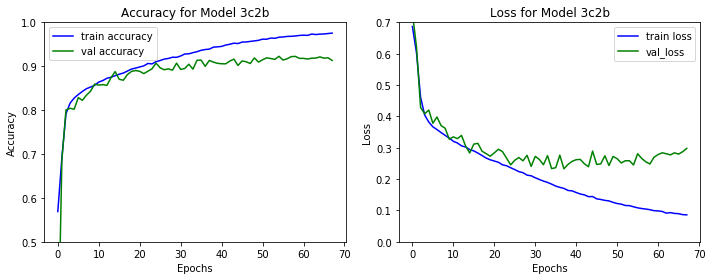

In [222]:
plot_accuracy_loss('Model 3c2b', model3c2b, (.5, 1), (0,.7))

In [223]:
y_train_pred3c2b = model3c2b.predict_classes(X_train_up, batch_size = 38040)
y_val_pred3c2b = model3c2b.predict_classes(X_val, batch_size = 5114)
y_train_prob3c2b = model3c2b.predict_proba(X_train_up, batch_size = 38040)
y_val_prob3c2b = model3c2b.predict_proba(X_val, batch_size = 5114)

In [224]:
compare_classification_metrics(y_train_up, y_train_pred3c2b, y_val, y_val_pred3c2b)

{'Train Accuracy': 0.98,
 'Train Precision': 0.96,
 'Train Recall': 1.0,
 'Train F1': 0.98,
 'Validation Accuracy': 0.91,
 'Validation Precision': 0.43,
 'Validation Recall': 0.73,
 'Validation F1': 0.54}

Adjusted Accuracy: 0.9350801720766523
Adjusted Precision: 0.5306122448979592
Adjusted Recall: 0.6518105849582173
Adjusted F1 Score: 0.5850000000000001




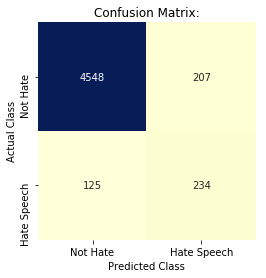

In [225]:
adj3c2b, cm3c2b = adjust_threshold_and_score(y_val, y_val_prob3c2b, .9, RNN = True)

## RNN 3c2 - with patience 30

In [233]:
model3c2 = Sequential()

# filepath = 'results/RNN/weights_3c2.best.hdf5'

callbacks = [EarlyStopping(monitor='val_loss', patience = 30), 
             ReduceLROnPlateau(monitor='val_loss', patience = 30)]
#              ModelCheckpoint(filepath, save_best_only = True, save_weights_only = True)]

model3c2.add(Embedding(num_words, 300, weights=[embedding_matrix300], input_length= 39, trainable=False))

model3c2.add(LSTM(64, activation='relu', return_sequences=True))
model3c2.add(BatchNormalization())

model3c2.add(LSTM(64, activation='relu'))
model3c2.add(BatchNormalization())

model3c2.add(Dense(1, activation='sigmoid'))

model3c2.compile(loss='binary_crossentropy', optimizer = rmsprop(lr=.000001), metrics=['accuracy']) #optimizer=Adam

print(model3c2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 39, 300)           11338500  
_________________________________________________________________
lstm_38 (LSTM)               (None, 39, 64)            93440     
_________________________________________________________________
batch_normalization_37 (Batc (None, 39, 64)            256       
_________________________________________________________________
lstm_39 (LSTM)               (None, 64)                33024     
_________________________________________________________________
batch_normalization_38 (Batc (None, 64)                256       
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 65        
Total params: 11,465,541
Trainable params: 126,785
Non-trainable params: 11,338,756
__________________________________________________________

In [234]:
history = model3c2.fit(X_train_up, 
                    y_train_up,
                    epochs=250,
                    batch_size=50,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val))

Train on 38040 samples, validate on 5114 samples
Epoch 1/250
38040/38040 [==============================] - 252s 7ms/step - loss: 0.7030 - acc: 0.5036 - val_loss: 0.7184 - val_acc: 0.2337
Epoch 2/250
38040/38040 [==============================] - 216s 6ms/step - loss: 0.6901 - acc: 0.5491 - val_loss: 0.7201 - val_acc: 0.3019
Epoch 3/250
38040/38040 [==============================] - 215s 6ms/step - loss: 0.6809 - acc: 0.5987 - val_loss: 0.7016 - val_acc: 0.4333
Epoch 4/250
38040/38040 [==============================] - 216s 6ms/step - loss: 0.6705 - acc: 0.6245 - val_loss: 0.6861 - val_acc: 0.6905
Epoch 5/250
38040/38040 [==============================] - 216s 6ms/step - loss: 0.6606 - acc: 0.6520 - val_loss: 0.6777 - val_acc: 0.6259
Epoch 6/250
38040/38040 [==============================] - 215s 6ms/step - loss: 0.6474 - acc: 0.6808 - val_loss: 0.6823 - val_acc: 0.5209
Epoch 7/250
38040/38040 [==============================] - 219s 6ms/step - loss: 0.6321 - acc: 0.7107 - val_loss: 0.6

38040/38040 [==============================] - 489s 13ms/step - loss: 0.3318 - acc: 0.8584 - val_loss: 0.3714 - val_acc: 0.8355
Epoch 60/250
38040/38040 [==============================] - 540s 14ms/step - loss: 0.3284 - acc: 0.8594 - val_loss: 0.3751 - val_acc: 0.8324
Epoch 61/250
38040/38040 [==============================] - 396s 10ms/step - loss: 0.3259 - acc: 0.8625 - val_loss: 0.3749 - val_acc: 0.8311
Epoch 62/250
38040/38040 [==============================] - 410s 11ms/step - loss: 0.3249 - acc: 0.8615 - val_loss: 0.3763 - val_acc: 0.8342
Epoch 63/250
38040/38040 [==============================] - 301s 8ms/step - loss: 0.3265 - acc: 0.8615 - val_loss: 0.3757 - val_acc: 0.8340
Epoch 64/250
38040/38040 [==============================] - 832s 22ms/step - loss: 0.3257 - acc: 0.8608 - val_loss: 0.3693 - val_acc: 0.8377
Epoch 65/250
38040/38040 [==============================] - 312s 8ms/step - loss: 0.3234 - acc: 0.8639 - val_loss: 0.3693 - val_acc: 0.8379
Epoch 66/250
38040/38040 [==

38040/38040 [==============================] - 270s 7ms/step - loss: 0.2789 - acc: 0.8858 - val_loss: 0.3510 - val_acc: 0.8553
Epoch 118/250
38040/38040 [==============================] - 261s 7ms/step - loss: 0.2747 - acc: 0.8890 - val_loss: 0.3579 - val_acc: 0.8535
Epoch 119/250
38040/38040 [==============================] - 281s 7ms/step - loss: 0.2741 - acc: 0.8898 - val_loss: 0.3463 - val_acc: 0.8580
Epoch 120/250
38040/38040 [==============================] - 242s 6ms/step - loss: 0.2729 - acc: 0.8913 - val_loss: 0.3482 - val_acc: 0.8571
Epoch 121/250
38040/38040 [==============================] - 238s 6ms/step - loss: 0.2711 - acc: 0.8915 - val_loss: 0.3381 - val_acc: 0.8619
Epoch 122/250
38040/38040 [==============================] - 240s 6ms/step - loss: 0.2730 - acc: 0.8908 - val_loss: 0.3375 - val_acc: 0.8580
Epoch 123/250
38040/38040 [==============================] - 238s 6ms/step - loss: 0.2726 - acc: 0.8900 - val_loss: 0.3304 - val_acc: 0.8629
Epoch 124/250
38040/38040 [

38040/38040 [==============================] - 228s 6ms/step - loss: 0.2334 - acc: 0.9091 - val_loss: 0.3014 - val_acc: 0.8735
Epoch 176/250
38040/38040 [==============================] - 229s 6ms/step - loss: 0.2338 - acc: 0.9102 - val_loss: 0.3071 - val_acc: 0.8721
Epoch 177/250
38040/38040 [==============================] - 228s 6ms/step - loss: 0.2345 - acc: 0.9098 - val_loss: 0.3018 - val_acc: 0.8735
Epoch 178/250
38040/38040 [==============================] - 239s 6ms/step - loss: 0.2327 - acc: 0.9105 - val_loss: 0.3005 - val_acc: 0.8754
Epoch 179/250
38040/38040 [==============================] - 228s 6ms/step - loss: 0.2305 - acc: 0.9103 - val_loss: 0.3095 - val_acc: 0.8723
Epoch 180/250
38040/38040 [==============================] - 230s 6ms/step - loss: 0.2322 - acc: 0.9105 - val_loss: 0.3142 - val_acc: 0.8727
Epoch 181/250
38040/38040 [==============================] - 229s 6ms/step - loss: 0.2301 - acc: 0.9112 - val_loss: 0.3116 - val_acc: 0.8731
Epoch 182/250
38040/38040 [

38040/38040 [==============================] - 224s 6ms/step - loss: 0.1971 - acc: 0.9294 - val_loss: 0.2844 - val_acc: 0.8838
Epoch 234/250
38040/38040 [==============================] - 223s 6ms/step - loss: 0.1968 - acc: 0.9282 - val_loss: 0.2885 - val_acc: 0.8842
Epoch 235/250
38040/38040 [==============================] - 227s 6ms/step - loss: 0.1978 - acc: 0.9289 - val_loss: 0.2813 - val_acc: 0.8854
Epoch 236/250
38040/38040 [==============================] - 220s 6ms/step - loss: 0.1984 - acc: 0.9280 - val_loss: 0.2923 - val_acc: 0.8850
Epoch 237/250
38040/38040 [==============================] - 222s 6ms/step - loss: 0.1967 - acc: 0.9273 - val_loss: 0.2838 - val_acc: 0.8870
Epoch 238/250
38040/38040 [==============================] - 219s 6ms/step - loss: 0.1949 - acc: 0.9299 - val_loss: 0.2895 - val_acc: 0.8815
Epoch 239/250
38040/38040 [==============================] - 233s 6ms/step - loss: 0.1961 - acc: 0.9286 - val_loss: 0.2988 - val_acc: 0.8815
Epoch 240/250
38040/38040 [

In [235]:
model3c2.save('results/RNN/models/model3c2.h5')
model3c2.save_weights('results/RNN/models/model3c2.weights.h5')
# model3c2b = model.load('results/RNN/models/model3c2.h5')

In [236]:
y_train_pred3c2 = model3c2.predict_classes(X_train_up, batch_size = 38040)
y_val_pred3c2 = model3c2.predict_classes(X_val, batch_size = 5114)
y_train_prob3c2 = model3c2.predict_proba(X_train_up, batch_size = 38040)
y_val_prob3c2 = model3c2.predict_proba(X_val, batch_size = 5114)

In [237]:
compare_classification_metrics(y_train_up, y_train_pred3c2, y_val, y_val_pred3c2)

{'Train Accuracy': 0.94,
 'Train Precision': 0.91,
 'Train Recall': 0.97,
 'Train F1': 0.94,
 'Validation Accuracy': 0.89,
 'Validation Precision': 0.36,
 'Validation Recall': 0.79,
 'Validation F1': 0.49}

Adjusted Accuracy: 0.9380132968322252
Adjusted Precision: 0.5596590909090909
Adjusted Recall: 0.5487465181058496
Adjusted F1 Score: 0.5541490857946555




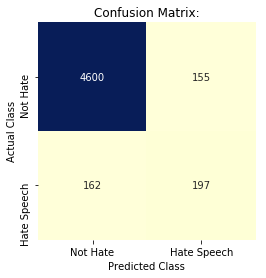

In [238]:
adj3c2, cm3c2 = adjust_threshold_and_score(y_val, y_val_prob3c2,.9, RNN = True)

## RNN 3d - upsampling;  using 3c parameters + Adam optimizer

In [263]:
model3d = Sequential()

# filepath = 'results/RNN/weights.best.hdf5'
csv_logger = CSVLogger('results/RNN/history_log/model3d.training.log')

callbacks = [EarlyStopping(monitor='val_loss', patience = 10), 
             ReduceLROnPlateau(monitor='val_loss', patience = 10),
            csv_logger]
#              ModelCheckpoint(filepath, save_best_only = True, save_weights_only = True)]

model3d.add(Embedding(num_words, 300, weights=[embedding_matrix300], input_length= 39, trainable=False))

model3d.add(LSTM(64, activation='relu', return_sequences=True))
model3d.add(BatchNormalization())

model3d.add(LSTM(64, activation='relu'))
model3d.add(BatchNormalization())

model3d.add(Dense(1, activation='sigmoid'))

model3d.compile(loss='binary_crossentropy', optimizer = Adam(lr=.00001), metrics=['accuracy'])

print(model3d.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 39, 300)           11338500  
_________________________________________________________________
lstm_45 (LSTM)               (None, 39, 64)            93440     
_________________________________________________________________
batch_normalization_44 (Batc (None, 39, 64)            256       
_________________________________________________________________
lstm_46 (LSTM)               (None, 64)                33024     
_________________________________________________________________
batch_normalization_45 (Batc (None, 64)                256       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 65        
Total params: 11,465,541
Trainable params: 126,785
Non-trainable params: 11,338,756
__________________________________________________________

In [ ]:
history = model3d.fit(X_train_up, 
                    y_train_up,
                    epochs=200,
                    batch_size=50,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val))

Train on 38040 samples, validate on 5114 samples
Epoch 1/200
38040/38040 [==============================] - 267s 7ms/step - loss: 0.6308 - acc: 0.6838 - val_loss: 0.4531 - val_acc: 0.8533
Epoch 2/200
38040/38040 [==============================] - 232s 6ms/step - loss: 0.4366 - acc: 0.8050 - val_loss: 0.3851 - val_acc: 0.8191
Epoch 3/200
38040/38040 [==============================] - 249s 7ms/step - loss: 0.3858 - acc: 0.8244 - val_loss: 0.4246 - val_acc: 0.7968
Epoch 4/200
18250/38040 [=============>................] - ETA: 2:15 - loss: 0.3732 - acc: 0.8323

In [ ]:
model3d.save('results/RNN/models/model3d.h5', overwrite = True)
model3d.save_weights('results/RNN/models/model3d.weights.h5', overwrite = True)
# model3d = model.load('results/RNN/models/model3d.h5')

In [ ]:
plot_accuracy_loss('Model 3d', model3d, (.6,1), (0,.8))

In [ ]:
y_train_pred3d = model3d.predict_classes(X_train_up, batch_size = 38040)
y_val_pred3d = model3d.predict_classes(X_val, batch_size = 5114)
y_train_prob3d = model3d.predict_proba(X_train_up, batch_size = 38040)
y_val_prob3d = model3d.predict_proba(X_val, batch_size = 5114)

In [ ]:
adj3d, cm3d = adjust_threshold_and_score(y_val, y_val_prob3d, .9, RNN = True)

In [ ]:
pd.DataFrame(y_train_prob3d).describe()

In [ ]:
seaborn_confusion_matrix(y_val, y_val_pred3d)

In [ ]:
compare_classification_metrics(y_train_up, y_train_pred3d, y_val, y_val_pred3d)

In [ ]:
y_adj_val3d, cm3d = adjust_threshold_and_score(y_val, y_val_prob3d, .84, RNN = True)

## RNN 3f - upsampling - reducing to one layer LSTM 

In [256]:
model3f = Sequential()

# filepath = 'results/RNN/weights.best.hdf5'
csv_logger = CSVLogger('results/RNN/history_log/model3f.training.log')

callbacks = [EarlyStopping(monitor='val_loss', patience = 30), 
             ReduceLROnPlateau(monitor='val_loss', patience = 30),
             csv_logger]
#              ModelCheckpoint(filepath, save_best_only = True, save_weights_only = True)]

model3f.add(Embedding(num_words, 300, weights=[embedding_matrix300], input_length= 39, trainable=False))

# model3f.add(LSTM(64, activation='relu', return_sequences=True))
# model3f.add(BatchNormalization())

model3f.add(LSTM(64, activation='relu'))
model3f.add(BatchNormalization())

model3f.add(Dense(1, activation='sigmoid'))

model3f.compile(loss='binary_crossentropy', optimizer = rmsprop(lr=.0001), metrics=['accuracy']) #optimizer=Adam

print(model3f.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 39, 300)           11338500  
_________________________________________________________________
lstm_43 (LSTM)               (None, 64)                93440     
_________________________________________________________________
batch_normalization_42 (Batc (None, 64)                256       
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 65        
Total params: 11,432,261
Trainable params: 93,633
Non-trainable params: 11,338,628
_________________________________________________________________
None


In [257]:
history = model3f.fit(X_train_up, 
                    y_train_up,
                    epochs=250,
                    batch_size=50,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val))

Train on 38040 samples, validate on 5114 samples
Epoch 1/250
38040/38040 [==============================] - 152s 4ms/step - loss: 0.4459 - acc: 0.8034 - val_loss: 0.3745 - val_acc: 0.8348
Epoch 2/250
38040/38040 [==============================] - 133s 4ms/step - loss: 0.3179 - acc: 0.8732 - val_loss: 0.2846 - val_acc: 0.8889
Epoch 3/250
38040/38040 [==============================] - 134s 4ms/step - loss: 0.2820 - acc: 0.8893 - val_loss: 0.4841 - val_acc: 0.7732
Epoch 4/250
38040/38040 [==============================] - 125s 3ms/step - loss: 0.2594 - acc: 0.9007 - val_loss: 0.3569 - val_acc: 0.8725
Epoch 5/250
38040/38040 [==============================] - 126s 3ms/step - loss: 0.2455 - acc: 0.9094 - val_loss: 0.3900 - val_acc: 0.8567
Epoch 6/250
38040/38040 [==============================] - 128s 3ms/step - loss: 0.2291 - acc: 0.9171 - val_loss: 0.2625 - val_acc: 0.9378
Epoch 7/250
38040/38040 [==============================] - 127s 3ms/step - loss: 0.2224 - acc: 0.9218 - val_loss: 0.2

In [258]:
model3f.save('results/RNN/models/model3f.h5')
model3f.save_weights('results/RNN/models/model3f.weights.h5')
# model3f = model.load('results/RNN/models/model3f.h5')

In [ ]:
plot_accuracy_loss('Model 3f', model3f, (.6,1), (0,.8))

In [259]:
y_train_pred3f = model3f.predict_classes(X_train_up, batch_size = 50)
y_val_pred3f = model3f.predict_classes(X_val, batch_size = 50)
y_train_prob3f = model3f.predict_proba(X_train_up, batch_size = 50)
y_val_prob3f = model3f.predict_proba(X_val, batch_size = 50)

In [727]:
pd.DataFrame(y_train_prob3f).describe()

,0
count,38040.000000
mean,0.406776
std,0.327530
min,0.000000
25%,0.079190
50%,0.363966
75%,0.731913
max,0.999998


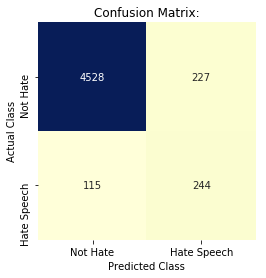

In [729]:
seaborn_confusion_matrix(y_val, y_val_pred3f)

In [730]:
compare_classification_metrics(y_train_up, y_train_pred3f, y_val, y_val_pred3f)

{'Train Accuracy': 0.91,
 'Train Precision': 0.96,
 'Train Recall': 0.86,
 'Train F1': 0.91,
 'Validation Accuracy': 0.93,
 'Validation Precision': 0.52,
 'Validation Recall': 0.68,
 'Validation F1': 0.59}

Adjusted Accuracy: 0.9489636292530309
Adjusted Precision: 0.6737588652482269
Adjusted Recall: 0.5292479108635098
Adjusted F1 Score: 0.5928237129485179




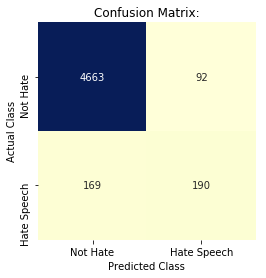

In [731]:
y_adj_val3f, cm3f = adjust_threshold_and_score(y_val, y_val_prob3f, .7, RNN = True)

## RNN 3g - upsampling with just 1 layer, increasing batch size to 100

-- got F1 up to .6 without adjustment (adjustment didn't increase F1).  Now trying to decrease learning rate to .00001 again to see if it helps, since the validation loss and accuracy were volatile

In [260]:
model3g = Sequential()

# filepath = 'results/RNN/weights.best.hdf5'
csv_logger = CSVLogger('results/RNN/history_log/model3g.training.log')

callbacks = [EarlyStopping(monitor='val_loss', patience = 30), 
             ReduceLROnPlateau(monitor='val_loss', patience = 30),
             csv_logger]
#              ModelCheckpoint(filepath, save_best_only = True, save_weights_only = True)]

model3g.add(Embedding(num_words, 300, weights=[embedding_matrix300], input_length= 39, trainable=False))

# model3f.add(LSTM(64, activation='relu', return_sequences=True))
# model3f.add(BatchNormalization())

model3g.add(LSTM(64, activation='relu'))
model3g.add(BatchNormalization())

model3g.add(Dense(1, activation='sigmoid'))

model3g.compile(loss='binary_crossentropy', optimizer = rmsprop(lr=.00001), metrics=['accuracy']) 

print(model3g.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 39, 300)           11338500  
_________________________________________________________________
lstm_44 (LSTM)               (None, 64)                93440     
_________________________________________________________________
batch_normalization_43 (Batc (None, 64)                256       
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 65        
Total params: 11,432,261
Trainable params: 93,633
Non-trainable params: 11,338,628
_________________________________________________________________
None


In [261]:
history = model3g.fit(X_train_up, 
                    y_train_up,
                    epochs=250,
                    batch_size=100,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val))

Train on 38040 samples, validate on 5114 samples
Epoch 1/250
38040/38040 [==============================] - 93s 2ms/step - loss: 0.6911 - acc: 0.6428 - val_loss: 0.6811 - val_acc: 0.8490
Epoch 2/250
38040/38040 [==============================] - 76s 2ms/step - loss: 0.6813 - acc: 0.7195 - val_loss: 0.6524 - val_acc: 0.8645
Epoch 3/250
38040/38040 [==============================] - 76s 2ms/step - loss: 0.6431 - acc: 0.7808 - val_loss: 0.5782 - val_acc: 0.8541
Epoch 4/250
38040/38040 [==============================] - 78s 2ms/step - loss: 0.5530 - acc: 0.8095 - val_loss: 0.5352 - val_acc: 0.8002
Epoch 5/250
38040/38040 [==============================] - 75s 2ms/step - loss: 0.4815 - acc: 0.8215 - val_loss: 0.5137 - val_acc: 0.7806
Epoch 6/250
38040/38040 [==============================] - 74s 2ms/step - loss: 0.4394 - acc: 0.8300 - val_loss: 0.4444 - val_acc: 0.8076
Epoch 7/250
38040/38040 [==============================] - 75s 2ms/step - loss: 0.4111 - acc: 0.8371 - val_loss: 0.4190 - v

38040/38040 [==============================] - 69s 2ms/step - loss: 0.1851 - acc: 0.9440 - val_loss: 0.2369 - val_acc: 0.9091
Epoch 60/250
38040/38040 [==============================] - 69s 2ms/step - loss: 0.1824 - acc: 0.9450 - val_loss: 0.2038 - val_acc: 0.9251
Epoch 61/250
38040/38040 [==============================] - 69s 2ms/step - loss: 0.1814 - acc: 0.9457 - val_loss: 0.2197 - val_acc: 0.9126
Epoch 62/250
38040/38040 [==============================] - 69s 2ms/step - loss: 0.1785 - acc: 0.9468 - val_loss: 0.2717 - val_acc: 0.8864
Epoch 63/250
38040/38040 [==============================] - 69s 2ms/step - loss: 0.1769 - acc: 0.9481 - val_loss: 0.2042 - val_acc: 0.9224
Epoch 64/250
38040/38040 [==============================] - 69s 2ms/step - loss: 0.1758 - acc: 0.9487 - val_loss: 0.2820 - val_acc: 0.8837
Epoch 65/250
38040/38040 [==============================] - 69s 2ms/step - loss: 0.1732 - acc: 0.9502 - val_loss: 0.2622 - val_acc: 0.8919
Epoch 66/250
38040/38040 [==============

Epoch 118/250
38040/38040 [==============================] - 71s 2ms/step - loss: 0.1222 - acc: 0.9720 - val_loss: 0.1941 - val_acc: 0.9321
Epoch 119/250
38040/38040 [==============================] - 70s 2ms/step - loss: 0.1197 - acc: 0.9725 - val_loss: 0.1890 - val_acc: 0.9339
Epoch 120/250
38040/38040 [==============================] - 70s 2ms/step - loss: 0.1201 - acc: 0.9723 - val_loss: 0.2172 - val_acc: 0.9202
Epoch 121/250
38040/38040 [==============================] - 75s 2ms/step - loss: 0.1189 - acc: 0.9730 - val_loss: 0.2045 - val_acc: 0.9286
Epoch 122/250
38040/38040 [==============================] - 73s 2ms/step - loss: 0.1183 - acc: 0.9728 - val_loss: 0.2179 - val_acc: 0.9216
Epoch 123/250
38040/38040 [==============================] - 72s 2ms/step - loss: 0.1181 - acc: 0.9730 - val_loss: 0.2143 - val_acc: 0.9253
Epoch 124/250
38040/38040 [==============================] - 74s 2ms/step - loss: 0.1174 - acc: 0.9731 - val_loss: 0.2207 - val_acc: 0.9224
Epoch 125/250
38040/

In [262]:
model3g.save('results/RNN/models/model3g.h5')
model3g.save_weights('results/RNN/models/model3g.weights.h5')
# model3g = model.load('results/RNN/models/model3g.h5')

In [ ]:
plot_accuracy_loss('Model 3g', model3g, (.6,1), (0,.8))

In [ ]:
y_train_pred3g = model3g.predict_classes(X_train_up, batch_size = 38040)
y_val_pred3g = model3g.predict_classes(X_val, batch_size = 5114)
y_train_prob3g = model3g.predict_proba(X_train_up, batch_size = 38040
y_val_prob3g = model3g.predict_proba(X_val, batch_size = 5114)

In [ ]:
pd.DataFrame(y_train_prob3g).describe()

In [ ]:
seaborn_confusion_matrix(y_train_up, y_train_pred3g)

In [ ]:
seaborn_confusion_matrix(y_val, y_val_pred3g)

In [ ]:
compare_classification_metrics(y_train_up, y_train_pred3g, y_val, y_val_pred3g)

In [ ]:
y_adj_val3g, cm3g = adjust_threshold_and_score(y_val, y_val_prob3g, .8, RNN = True)

## RNN 4 - class weight balanced

In [ ]:
model4 = Sequential()

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

csv_logger = CSVLogger('results/RNN/history_log/model4.training.log')

# filepath = 'results/RNN/weights_model4.best.hdf5'

callbacks = [EarlyStopping(monitor='val_loss', patience = 10), 
             ReduceLROnPlateau(monitor='val_loss', patience = 10),
             csv_logger]
#              ModelCheckpoint(filepath, save_best_only = True, save_weights_only = True)]

model4.add(Embedding(num_words, 300, weights=[embedding_matrix300], input_length= 39, trainable=False))

model4.add(LSTM(64, activation='relu', return_sequences=True))
model4.add(BatchNormalization())

model4.add(LSTM(64, activation='relu'))
model4.add(BatchNormalization())

model4.add(Dense(1, activation='sigmoid'))

model4.compile(loss='binary_crossentropy', optimizer = rmsprop(lr=.000001), metrics=['accuracy'])

print(model4.summary())

In [ ]:
history = model4.fit(X_train, 
                    y_train,
                    epochs=200,
                    batch_size=50,
                    callbacks=callbacks,
                    class_weight=class_weights,
                    validation_data=(X_val, y_val))

In [ ]:
model4.save('results/RNN/models/model4.h5', overwrite = True)
model4.save_weights('results/RNN/models/model4.weights.h5', overwrite = True)
# model4 = model.load('results/RNN/models/model4.h5')

In [ ]:
plot_accuracy_loss('Model 4', model4, (.6,1), (0,.8))

In [ ]:
y_train_pred4 = model4.predict_classes(X_train, batch_size = 20455)
y_val_pred4 = model4.predict_classes(X_val, batch_size = 5114)
y_train_prob4 = model4.predict_proba(X_train, batch_size = 20455)
y_val_prob4 = model4.predict_proba(X_val, batch_size = 5114)

In [ ]:
pd.DataFrame(y_train_prob4).describe()

In [ ]:
seaborn_confusion_matrix(y_val, y_val_pred4)

In [ ]:
y_adj_val4, cm4 = adjust_threshold_and_score(y_val, y_val_prob4, .8, RNN = True)

# Building Word 2 Vec Models 

### 100 Dimension Model 

In [25]:
from time import time
t = time()

RNN_w2v_model = gensim.models.Word2Vec(X_token_list, sg=1, min_count=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.13 mins


In [26]:
RNN_w2v_model.build_vocab

<bound method BaseWordEmbeddingsModel.build_vocab of <gensim.models.word2vec.Word2Vec object at 0x1a3ea3d940>>

In [27]:
RNN_w2v_model.train(X_token_list, total_examples=RNN_w2v_model.corpus_count, epochs=RNN_w2v_model.epochs)

(1650113, 1980385)

In [28]:
RNN_w2v_model.save('data/RNN_w2v.model')

In [29]:
RNN_w2v_model = gensim.models.Word2Vec.load('data/RNN_w2v.model')

### 300 Dimension Model 

In [27]:
RNN_w2vmodel300 = gensim.models.Word2Vec(X_token_list, sg=1, min_count=1, size = 300)

In [28]:
RNN_w2vmodel300.build_vocab

<bound method BaseWordEmbeddingsModel.build_vocab of <gensim.models.word2vec.Word2Vec object at 0x10a8472b0>>

In [29]:
RNN_w2vmodel300.train(X_token_list, total_examples=RNN_w2vmodel300.corpus_count, 
                   epochs=RNN_w2vmodel300.epochs)

(1650650, 1980385)

In [30]:
RNN_w2vmodel300.save('data/RNN_w2v300.model')

In [31]:
RNN_w2vmodel300 = gensim.models.Word2Vec.load('data/RNN_w2v300.model')

In [ ]:
num_words = 37795
EMBEDDING_DIM = 300
embedding_matrix300 = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    print(word, i)
    if word in RNN_w2vmodel300.wv.vocab:
        embedding_matrix300[i] = RNN_w2vmodel300.wv.word_vec(word)
# print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix300, axis=1) == 0))